In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from rethinking import HPDI, PI, LM, MAP, dens, glimmer, precis, quantile

plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["lines.linewidth"] = 1
pyro.set_rng_seed(0)

#### Code 5.1

In [2]:
# load data
waffle_divorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = waffle_divorce
d_median_age_marriage = torch.tensor(d["MedianAgeMarriage"].values, dtype=torch.float)
d_divorce = torch.tensor(d["Divorce"].values, dtype=torch.float)
d_marriage = torch.tensor(d["Marriage"].values, dtype=torch.float)

# standardize predictor
d_median_age_marriage_s = ((d_median_age_marriage - d_median_age_marriage.mean())
                           / d_median_age_marriage.std())

# fit model
def m5_1_model(predictor, outcome):
    a = pyro.sample("a", dist.Normal(10, 10))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + bA * predictor
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("outcome", dist.Normal(mu, sigma), obs=outcome)

m5_1 = MAP("m5.1", m5_1_model, predictor=d_median_age_marriage_s, outcome=d_divorce)
m5_1.fit();

#### Code 5.2

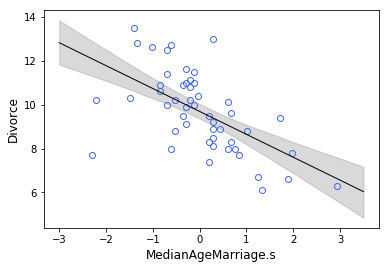

In [3]:
# compute percentile interval of mean
MAM_seq = torch.linspace(start=-3, end=3.5, steps=30)
mu = m5_1.link(predictor=MAM_seq)
mu_PI = PI(mu, dim=0)

# plot it all
plt.plot(d_median_age_marriage_s.tolist(), d_divorce.tolist(), "o", c="royalblue",
         fillstyle="none")
plt.xlabel("MedianAgeMarriage.s")
plt.ylabel("Divorce")
x = torch.linspace(-3, 3.5, 101)
plt.plot(x.tolist(), (m5_1.coef()["a"] + m5_1.coef()["bA"] * x).tolist(), "k")
plt.fill_between(MAM_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15);

#### Code 5.3

In [4]:
d_marriage_s = (d_marriage - d_marriage.mean()) / d_marriage.std()
m5_2 = MAP("m5.2", m5_1_model, predictor=d_marriage_s, outcome=d_divorce)
m5_2.fit();

#### Code 5.4

In [5]:
def m5_3_model(marriage, median_age_marriage, divorce):
    a = pyro.sample("a", dist.Normal(10, 10))
    bR = pyro.sample("bR", dist.Normal(0, 1))
    bA = pyro.sample("bA", dist.Normal(0, 1))
    mu = a + bR * marriage + bA * median_age_marriage
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("Divorce", dist.Normal(mu, sigma), obs=divorce)

m5_3 = MAP("m5.3", m5_3_model, marriage=d_marriage_s,
           median_age_marriage=d_median_age_marriage_s, divorce=d_divorce)
m5_3.fit()
m5_3.precis()

,Mean,StdDev,5.5%,94.5%
a,9.69,0.21,9.36,10.02
bR,-0.11,0.28,-0.57,0.34
bA,-1.15,0.28,-1.61,-0.70
sigma,1.46,0.15,1.22,1.71


#### Code 5.5

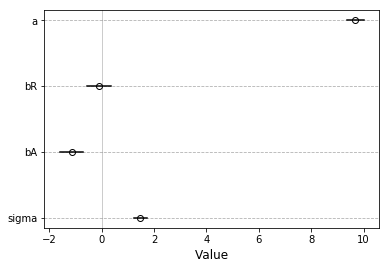

In [6]:
m5_3.precis_plot()

#### Code 5.6

In [7]:
m5_4 = MAP("m5.4", m5_1_model, predictor=d_median_age_marriage_s, outcome=d_marriage_s)
m5_4.fit();

#### Code 5.7

In [8]:
# compute expected value at MAP, for each State
mu = m5_4.coef()["a"] + m5_4.coef()["bA"] * d_median_age_marriage_s
# compute residual for each State
m_resid = d_marriage_s - mu

#### Code 5.8

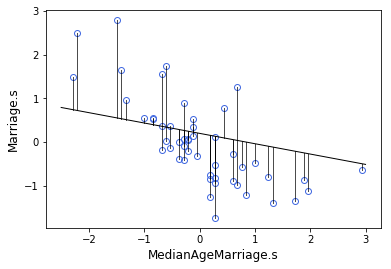

In [9]:
plt.plot(d_median_age_marriage_s.tolist(), d_marriage_s.tolist(), "o", c="royalblue",
         fillstyle="none")
plt.xlabel("MedianAgeMarriage.s")
plt.ylabel("Marriage.s")
x = torch.linspace(-2.5, 3, 101)
plt.plot(x.tolist(), (m5_4.coef()["a"] + m5_4.coef()["bA"] * x).tolist(), "k")
# loop over States
for i in range(len(m_resid)):
    x = d_median_age_marriage_s[i]  # x location of line segment
    y = d_marriage_s[i]  # observed endpoint of line segment
    # draw the line segment
    plt.plot([x, x], [mu[i], y], "k", alpha=0.7);

#### Code 5.9

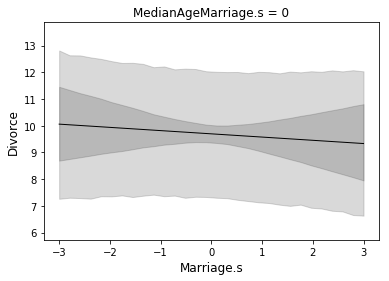

In [10]:
# prepare new counterfactual data
A_avg = d_median_age_marriage_s.mean()
R_seq = torch.linspace(start=-3, end=3, steps=30)
pred_data = {"marriage": R_seq, "median_age_marriage": A_avg.expand_as(R_seq)}

# compute counterfactual mean divorce (mu)
mu = m5_3.link(**pred_data)
mu_mean = mu.mean(0)
mu_PI = PI(mu, dim=0)

# simulate counterfactual divorce outcomes
R_sim = m5_3.sim(n=int(1e4), **pred_data)
R_PI = PI(R_sim, dim=0)

# display predictions, hiding raw data with visible=False
plt.plot(d_marriage_s.tolist(), d_divorce.tolist(), visible=False)
plt.xlabel("Marriage.s")
plt.ylabel("Divorce")
plt.title("MedianAgeMarriage.s = 0")
plt.plot(R_seq.tolist(), mu_mean.tolist(), "k")
plt.fill_between(R_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15)
plt.fill_between(R_seq, R_PI[0], R_PI[1], color="k", alpha=0.15);

#### Code 5.10

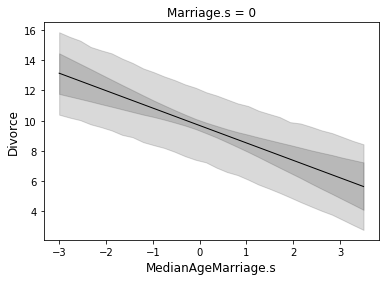

In [11]:
R_avg = d_marriage_s.mean()
A_seq = torch.linspace(start=-3, end=3.5, steps=30)
pred_data2 = {"marriage": R_avg.expand_as(A_seq), "median_age_marriage": A_seq}

mu = m5_3.link(**pred_data2)
mu_mean = mu.mean(0)
mu_PI = PI(mu, dim=0)

A_sim = m5_3.sim(n=int(1e4), **pred_data2)
A_PI = PI(A_sim, dim=0)

plt.plot(d_median_age_marriage_s.tolist(), d_divorce.tolist(), visible=False)
plt.xlabel("MedianAgeMarriage.s")
plt.ylabel("Divorce")
plt.title("Marriage.s = 0")
plt.plot(A_seq.tolist(), mu_mean.tolist(), "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.15)
plt.fill_between(A_seq, A_PI[0], A_PI[1], color="k", alpha=0.15);

#### Code 5.11

In [12]:
# call link without specifying new data
# so it uses original data
mu = m5_3.link()

# summarize samples across cases
mu_mean = mu.mean(0)
mu_PI = PI(mu, dim=0)

# simulate observations
# again no new data, so uses original data
divorce_sim = m5_3.sim(n=int(1e4))
divorce_PI = PI(divorce_sim, dim=0)

#### Code 5.12

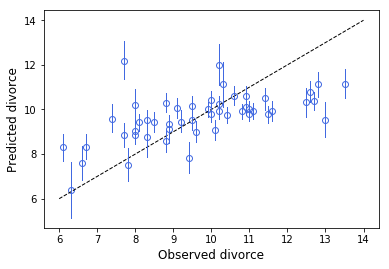

In [13]:
fig, ax = plt.subplots()
ax.plot(d_divorce.tolist(), mu_mean.tolist(), "o", c="royalblue", fillstyle="none")
ax.set_xlabel("Observed divorce")
ax.set_ylabel("Predicted divorce")
x = torch.linspace(6, 14, 101)
ax.plot(x.tolist(), x.tolist(), "k--")
for i in range(d.shape[0]):
    ax.plot([d_divorce[i]] * 2, [mu_PI[0, i], mu_PI[1, i]], c="royalblue");

#### Code 5.13

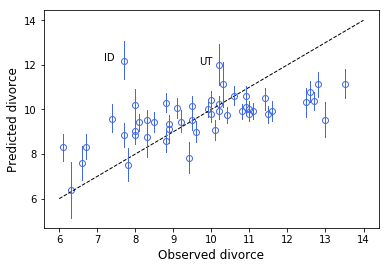

In [14]:
identify = mu_mean.sort(descending=True)[1][:2]
for i in identify:
    ax.annotate(d["Loc"][i], (d_divorce[i], mu_mean[i]), xytext=(-20, 0),
                textcoords="offset pixels")
fig

#### Code 5.14

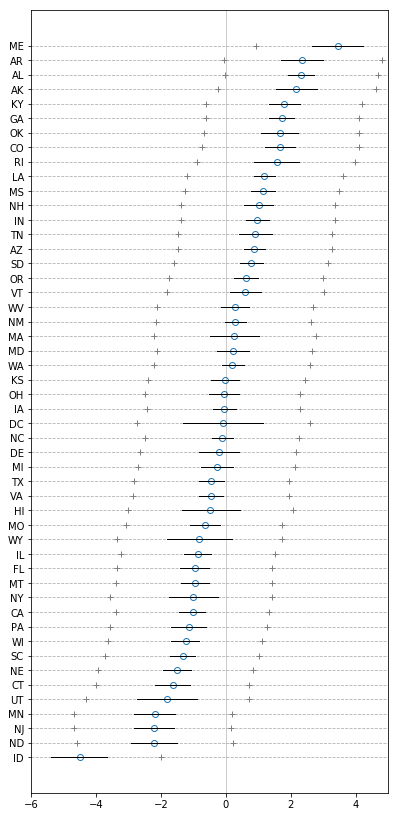

In [15]:
# compute residuals
divorce_resid = d_divorce - mu_mean
# get ordering by divorce rate
o = divorce_resid.sort()[1]
# make the plot
plt.figure(figsize=(6.4, 14.4))
plt.plot(divorce_resid[o].tolist(), d["Loc"][o.tolist()], "o", fillstyle="none")
plt.xlim(-6, 5)
plt.grid(axis="y", linestyle="--")
plt.axvline(x=0, c="k", alpha=0.2)
for i in range(d.shape[0]):
    j = o[i].item()  # which State in order
    plt.plot((d_divorce[j] - mu_PI[:, j]).tolist(), [i] * 2, "k")
    plt.plot((d_divorce[j] - divorce_PI[:, j]).tolist(), [i] * 2, "+", c="gray");

#### Code 5.15

In [16]:
N = 100  # number of cases
x_real = torch.randn(N)  # x_real as Gaussian with mean 0 and stddev 1
x_spur = dist.Normal(x_real, 1).sample()  # x_spur as Gaussian with mean=x_real
y = dist.Normal(x_real, 1).sample()  # y as Gaussian with mean=x_real
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

#### Code 5.16

In [17]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d_neocortex_perc = torch.tensor(d["neocortex.perc"].values, dtype=torch.float)
d_kcal_per_g = torch.tensor(d["kcal.per.g"].values, dtype=torch.float)
d_mass = torch.tensor(d["mass"].values, dtype=torch.float)
print(d.info())
print(d.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
clade             29 non-null object
species           29 non-null object
kcal.per.g        29 non-null float64
perc.fat          29 non-null float64
perc.protein      29 non-null float64
perc.lactose      29 non-null float64
mass              29 non-null float64
neocortex.perc    17 non-null float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB
None
           clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09     

#### Code 5.17

In [18]:
def m5_5_model(predictor, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bn = pyro.sample("bn", dist.Normal(0, 1))
    mu = a + bn * predictor
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

# fit model
m5_5 = MAP("m5.5", m5_5_model, predictor=d_neocortex_perc, kcal_per_g=d_kcal_per_g)
m5_5.fit();

/home/fehiepsi/pyro/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


#### Code 5.18

In [19]:
d_neocortex_perc

tensor([55.1600,     nan,     nan,     nan,     nan, 64.5400, 64.5400, 67.6400,
            nan, 68.8500, 58.8500, 61.6900, 60.3200,     nan,     nan, 69.9700,
            nan, 70.4100,     nan, 73.4000,     nan, 67.5300,     nan, 71.2600,
        72.6000,     nan, 70.2400, 76.3000, 75.4900])

#### Code 5.19

In [20]:
isnan = torch.isnan(d_neocortex_perc)
dcc_kcal_per_g = d_kcal_per_g[~isnan]
dcc_mass = d_mass[~isnan]
dcc_neocortex_perc = d_neocortex_perc[~isnan]

#### Code 5.20

In [21]:
m5_5 = MAP("m5.5_dcc", m5_5_model, start="mean",
           predictor=dcc_neocortex_perc, kcal_per_g=dcc_kcal_per_g)
m5_5.fit(lr=0.01);

#### Code 5.21

In [22]:
m5_5.precis(digits=3)

,Mean,StdDev,5.5%,94.5%
a,0.342,0.470,-0.410,1.093
bn,0.005,0.007,-0.006,0.016
sigma,0.165,0.028,0.120,0.211


#### Code 5.22

In [23]:
m5_5.coef()["bn"] * (76 - 55)

tensor(0.0973)

#### Code 5.23

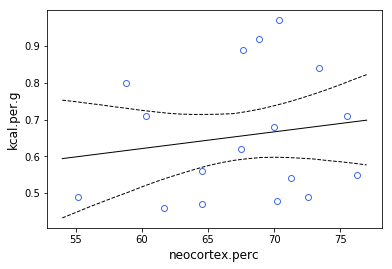

In [24]:
np_seq = torch.arange(100, dtype=torch.float)
pred_data = {"predictor": np_seq}

mu = m5_5.link(n=int(1e4), **pred_data)
mu_mean = mu.mean(0)
mu_PI = PI(mu, dim=0)

plt.plot(dcc_neocortex_perc.tolist(), dcc_kcal_per_g.tolist(), "o", c="royalblue",
         fillstyle="none")
plt.xlabel("neocortex.perc")
plt.ylabel("kcal.per.g")
plt.plot(np_seq[54:78].tolist(), mu_mean[54:78].tolist(), "k")
plt.plot(np_seq[54:78].tolist(), mu_PI[0, 54:78].tolist(), "k--")
plt.plot(np_seq[54:78].tolist(), mu_PI[1, 54:78].tolist(), "k--");

#### Code 5.24

In [25]:
dcc_log_mass = dcc_mass.log()

#### Code 5.25

In [26]:
m5_6 = MAP("m5.6", m5_5_model, start="mean",
           predictor=dcc_log_mass, kcal_per_g=dcc_kcal_per_g)
m5_6.fit(lr=0.01)
m5_6.precis()

,Mean,StdDev,5.5%,94.5%
a,0.71,0.05,0.63,0.78
bn,-0.03,0.02,-0.06,0.00
sigma,0.16,0.03,0.11,0.20


#### Code 5.26

In [27]:
def m5_7_model(neocortex_perc, log_mass, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0, 100))
    bn = pyro.sample("bn", dist.Normal(0, 1))
    bm = pyro.sample("bm", dist.Normal(0, 1))
    mu = a + bn * neocortex_perc + bm * log_mass
    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_7 = MAP("m5.7", m5_7_model, start="mean", neocortex_perc=dcc_neocortex_perc,
           log_mass=dcc_log_mass, kcal_per_g=dcc_kcal_per_g)
m5_7.fit(lr=0.01, num_steps=2000)
m5_7.precis()

,Mean,StdDev,5.5%,94.5%
a,-1.05,0.47,-1.80,-0.30
bn,0.03,0.01,0.02,0.04
bm,-0.10,0.02,-0.13,-0.06
sigma,0.12,0.02,0.08,0.15


#### Code 5.27

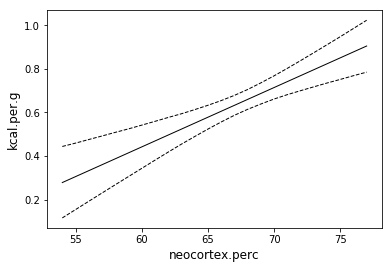

In [28]:
mean_log_mass = dcc_mass.log().mean()
np_seq = torch.arange(100, dtype=torch.float)
pred_data = {"neocortex_perc": np_seq, "log_mass": mean_log_mass.repeat(100)}

mu = m5_7.link(n=int(1e4), **pred_data)
mu_mean = mu.mean(0)
mu_PI = PI(mu, dim=0)

plt.plot(dcc_neocortex_perc.tolist(), dcc_kcal_per_g.tolist(), "o", visible=False)
plt.xlabel("neocortex.perc")
plt.ylabel("kcal.per.g")
plt.plot(np_seq[54:78].tolist(), mu_mean[54:78].tolist(), "k")
plt.plot(np_seq[54:78].tolist(), mu_PI[0, 54:78].tolist(), "k--")
plt.plot(np_seq[54:78].tolist(), mu_PI[1, 54:78].tolist(), "k--");

#### Code 5.28

In [29]:
N = 100  # number of cases
rho = 0.7  # correlation btw x_pos and x_neg
x_pos = torch.randn(N)  # x_pos as Gaussian
# x_neg correlated with x_pos
x_neg = dist.Normal(rho * x_pos, (1 - rho**2) ** 0.5).sample()
y = dist.Normal(x_pos - x_neg, 1).sample()  # y equally associated with x_pos, x_neg
d = pd.DataFrame({"y": y, "x_pos": x_pos, "x_neg": x_neg})

#### Code 5.29

In [30]:
N = 100  # number of individuals
height = torch.empty(N).normal_(10, 2)  # sim total height of each
leg_prop = torch.empty(N).uniform_(0.4, 0.5)  # leg as proportion of height
# sim left leg as proportion + error
leg_left = leg_prop * height + torch.empty(N).normal_(0, 0.02)
# sim right leg as proportion + error
leg_right = leg_prop * height + torch.empty(N).normal_(0, 0.02)
# combine into data dict
d = {"height": height, "leg_left": leg_left, "leg_right": leg_right}

#### Code 5.30

In [31]:
def m5_8_model(leg_left, leg_right, height):
    a = pyro.sample("a", dist.Normal(10, 100))
    bl = pyro.sample("bl", dist.Normal(2, 10))
    br = pyro.sample("br", dist.Normal(2, 10))
    mu = a + bl * leg_left + br * leg_right
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_8 = MAP("m5.8", m5_8_model, start="mean", **d)
m5_8.fit(lr=0.1)
m5_8.precis()

,Mean,StdDev,5.5%,94.5%
a,0.65,0.34,0.10,1.19
bl,1.95,2.15,-1.49,5.40
br,0.16,2.15,-3.28,3.60
sigma,0.63,0.05,0.56,0.70


#### Code 5.31

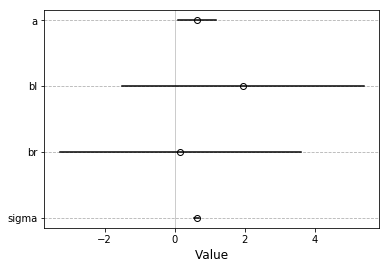

In [32]:
m5_8.precis_plot()

#### Code 5.32

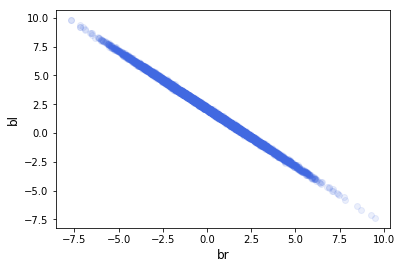

In [33]:
post = m5_8.extract_samples()
plt.plot(post["br"].tolist(), post["bl"].tolist(), "o", c="royalblue", alpha=0.1)
plt.xlabel("br")
plt.ylabel("bl");

#### Code 5.33

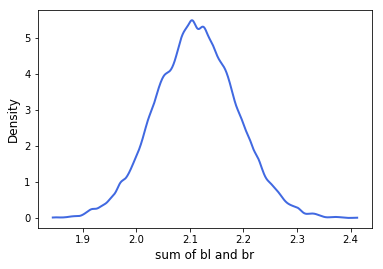

In [34]:
sum_blbr = post["bl"] + post["br"]
dens(sum_blbr, c="royalblue", lw=2, xlab="sum of bl and br")

#### Code 5.34

In [35]:
def m5_9_model(leg_left, height):
    a = pyro.sample("a", dist.Normal(10, 100))
    bl = pyro.sample("bl", dist.Normal(2, 10))
    mu = a + bl * leg_left
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_9 = MAP("m5.9", m5_9_model, start="mean", leg_left=leg_left, height=height)
m5_9.fit(lr=0.1)
m5_9.precis()

,Mean,StdDev,5.5%,94.5%
a,0.64,0.34,0.10,1.18
bl,2.11,0.07,1.99,2.23
sigma,0.63,0.04,0.56,0.70


#### Code 5.35

In [36]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d_perc_fat = torch.tensor(d["perc.fat"].values, dtype=torch.float)
d_kcal_per_g = torch.tensor(d["kcal.per.g"].values, dtype=torch.float)
d_perc_lactose = torch.tensor(d["perc.lactose"].values, dtype=torch.float)

#### Code 5.36

In [37]:
# kcal.per.g regressed on perc.fat
def m5_10_model(predictor, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    bf = pyro.sample("bf", dist.Normal(0, 1))
    mu = a + bf * predictor
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_10 = MAP("m5.10", m5_10_model, start="mean",
            predictor=d_perc_fat, kcal_per_g=d_kcal_per_g)
m5_10.fit(lr=0.01)

# kcal.per.g regressed on perc.lactose
m5_11 = MAP("m5.11", m5_10_model, start="mean",
            predictor=d_perc_lactose, kcal_per_g=d_kcal_per_g)
m5_11.fit(lr=0.01)

print(m5_10.precis(digits=3))
print(m5_11.precis(digits=3))

        Mean  StdDev   5.5%  94.5%
a      0.301   0.037  0.242  0.360
bf     0.010   0.001  0.009  0.012
sigma  0.076   0.010  0.059  0.092
        Mean  StdDev   5.5%  94.5%
a      1.166   0.043  1.098  1.235
bf    -0.011   0.001 -0.012 -0.009
sigma  0.062   0.008  0.049  0.075


#### Code 5.37

In [38]:
def m5_12_model(perc_fat, perc_lactose, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    bf = pyro.sample("bf", dist.Normal(0, 1))
    bl = pyro.sample("bl", dist.Normal(0, 1))
    mu = a + bf * perc_fat + bl * perc_lactose
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_12 = MAP("m5.12", m5_12_model, start="mean", perc_fat=d_perc_fat,
            perc_lactose=d_perc_lactose, kcal_per_g=d_kcal_per_g)
m5_12.fit(lr=0.01, num_steps=2000)
m5_12.precis(digits=3)

,Mean,StdDev,5.5%,94.5%
a,0.962,0.203,0.637,1.286
bf,0.002,0.002,-0.001,0.006
bl,-0.008,0.002,-0.012,-0.004
sigma,0.062,0.008,0.049,0.075


#### Code 5.38

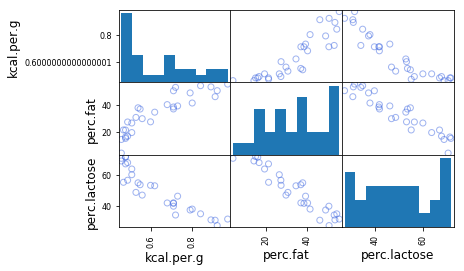

In [39]:
pd.plotting.scatter_matrix(d[["kcal.per.g", "perc.fat", "perc.lactose"]],
                           marker="o", facecolors="none", edgecolor="royalblue");

#### Code 5.39

In [40]:
d[["perc.fat", "perc.lactose"]].corr().iloc[0, 1]

-0.9416373456839282

#### Code 5.40

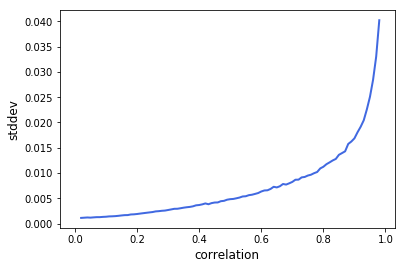

In [41]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d_perc_fat = torch.tensor(d["perc.fat"].values, dtype=torch.float)
d_kcal_per_g = torch.tensor(d["kcal.per.g"].values, dtype=torch.float)

def sim_coll(r=0.9, i=0):
    d_x = dist.Normal(loc=(r * d_perc_fat),
                      scale=((1 - r**2) * d_perc_fat.std()).sqrt()).sample()
    m = LM("m_r{}_{}".format(r, i), perc_fat=d_perc_fat, x=d_x, kcal_per_g=d_kcal_per_g)
    m.fit(lr=0.01, num_steps=100)
    return m.vcov().diag().sqrt()[1]  # stddev of parameter

def rep_sim_coll(r=0.9, n=100):
    stddev = torch.stack([sim_coll(r, i) for i in range(n)])
    return stddev.mean()

r_seq = torch.arange(start=0, end=0.99, step=0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]
plt.plot(r_seq.tolist(), stddev, c="royalblue", lw=2)
plt.xlabel("correlation")
plt.ylabel("stddev");

#### Code 5.41

In [42]:
# number of plants
N = 100

# simulate initial heights
h0 = torch.empty(N).normal_(10, 2)

# assign treatments and simulate fungus and growth
treatment = torch.tensor([0., 1]).unsqueeze(-1).repeat(1, N // 2).reshape(-1)
fungus = dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4)).sample()
h1 = h0 + dist.Normal(5 - 3 * fungus, 1).sample()

# compose a clean data dict
d = {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus}

#### Code 5.42

In [43]:
def m5_13_model(h0, treatment, fungus, h1):
    a = pyro.sample("a", dist.Normal(0, 100))
    bh = pyro.sample("bh", dist.Normal(0, 10))
    bt = pyro.sample("bt", dist.Normal(0, 10))
    bf = pyro.sample("bf", dist.Normal(0, 10))
    mu = a + bh * h0 + bt * treatment + bf * fungus
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m5_13 = MAP("m5.13", m5_13_model, start="mean", **d)
m5_13.fit(lr=0.1)
m5_13.precis()

,Mean,StdDev,5.5%,94.5%
a,5.38,0.47,4.63,6.13
bh,0.94,0.04,0.87,1.02
bt,0.35,0.20,0.03,0.66
bf,-2.92,0.21,-3.26,-2.57
sigma,0.86,0.06,0.76,0.96


#### Code 5.43

In [44]:
def m5_14_model(h0, treatment, h1):
    a = pyro.sample("a", dist.Normal(0, 100))
    bh = pyro.sample("bh", dist.Normal(0, 10))
    bt = pyro.sample("bt", dist.Normal(0, 10))
    mu = a + bh * h0 + bt * treatment
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m5_14 = MAP("m5.14", m5_14_model, start="mean", h0=h0, treatment=treatment, h1=h1)
m5_14.fit(lr=0.1)
m5_14.precis()

,Mean,StdDev,5.5%,94.5%
a,3.40,0.75,2.19,4.60
bh,0.99,0.08,0.87,1.11
bt,1.64,0.29,1.18,2.10
sigma,1.45,0.10,1.29,1.61


#### Code 5.44

In [45]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d_male = torch.tensor(d["male"].values, dtype=torch.float)
d_height = torch.tensor(d["height"].values, dtype=torch.float)
print(d.info())
print(d.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None
    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0


#### Code 5.45

In [46]:
def m5_15_model(male, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    bm = pyro.sample("bm", dist.Normal(0, 10))
    mu = a + bm * male
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_15 = MAP("m5_15", m5_15_model, start="mean", male=d_male, height=d_height)
m5_15.fit()
m5_15.precis()

,Mean,StdDev,5.5%,94.5%
a,134.83,1.59,132.29,137.37
bm,7.28,2.28,3.63,10.93
sigma,27.31,0.83,25.99,28.63


#### Code 5.46

In [47]:
post = m5_15.extract_samples()
mu_male = post["a"] + post["bm"]
PI(mu_male)

tensor([139.3789, 144.8143])

#### Code 5.47

In [48]:
def m5_15b_model(male, height):
    af = pyro.sample("af", dist.Normal(178, 100))
    am = pyro.sample("am", dist.Normal(178, 100))
    mu = af * (1 - male) + am * male
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_15b = MAP("m5_15b", m5_15b_model, start="mean", male=d_male, height=d_height)
m5_15b.fit();

#### Code 5.48

In [49]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d_kcal_per_g = torch.tensor(d["kcal.per.g"].values, dtype=torch.float)
d["clade"].unique().tolist()

['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape']

#### Code 5.49

In [50]:
d_clade_NWM = torch.tensor(d["clade"] == "New World Monkey", dtype=torch.float)
d_clade_NWM

tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Code 5.50

In [51]:
d_clade_OWM = torch.tensor(d["clade"] == "Old World Monkey", dtype=torch.float)
d_clade_S = torch.tensor(d["clade"] == "Strepsirrhine", dtype=torch.float)

#### Code 5.51

In [52]:
def m5_16_model(nwm, owm, s, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10))
    b_NWM = pyro.sample("b.NWM", dist.Normal(0, 1))
    b_OWM = pyro.sample("b.OWM", dist.Normal(0, 1))
    b_S = pyro.sample("b.S", dist.Normal(0, 1))
    mu = a + b_NWM * nwm + b_OWM * owm + b_S * s
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_16 = MAP("m5_16", m5_16_model, nwm=d_clade_NWM, owm=d_clade_OWM, s=d_clade_S,
            kcal_per_g=d_kcal_per_g)
m5_16.fit(lr=0.1)
m5_16.precis()

,Mean,StdDev,5.5%,94.5%
a,0.55,0.04,0.49,0.61
b.NWM,0.17,0.05,0.08,0.25
b.OWM,0.24,0.06,0.15,0.34
b.S,-0.04,0.06,-0.14,0.06
sigma,0.11,0.02,0.09,0.14


#### Code 5.52

In [53]:
# sample posterior
post = m5_16.extract_samples()

# compute averages for each category
mu_ape = post["a"]
mu_NWM = post["a"] + post["b.NWM"]
mu_OWM = post["a"] + post["b.OWM"]
mu_S = post["a"] + post["b.S"]

# summarize using precis
precis({"mu.ape": mu_ape, "mu.NWM": mu_NWM, "mu.OWM": mu_OWM, "mu.S": mu_S})

,Mean,StdDev,|0.89,0.89|
mu.ape,0.55,0.04,0.48,0.61
mu.NWM,0.71,0.04,0.65,0.77
mu.OWM,0.79,0.05,0.71,0.87
mu.S,0.51,0.05,0.43,0.59


#### Code 5.53

In [54]:
diff_NWM_OWM = mu_NWM - mu_OWM
quantile(diff_NWM_OWM, probs=(0.025, 0.5, 0.975))

tensor([-0.1933, -0.0723,  0.0439])

#### Code 5.54

In [55]:
d_clade_id = torch.tensor(d["clade"].astype("category").cat.codes, dtype=torch.long)
d_clade_id

tensor([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

#### Code 5.55

In [56]:
def m5_16_alt_model(clade_id, kcal_per_g):
    a = pyro.sample("a", dist.Normal(0.6, 10).expand(d_clade_id.unique().shape))
    mu = a[clade_id]
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    pyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

m5_16_alt = MAP("m5.16_alt", m5_16_alt_model, clade_id=d_clade_id, kcal_per_g=d_kcal_per_g)
m5_16_alt.fit(lr=0.1)
m5_16_alt.precis(depth=2)

,Mean,StdDev,5.5%,94.5%
a[0],0.55,0.04,0.48,0.61
a[1],0.71,0.04,0.65,0.78
a[2],0.79,0.05,0.71,0.86
a[3],0.51,0.05,0.43,0.59
sigma,0.11,0.02,0.09,0.14


#### Code 5.56

In [57]:
d_x = d_y = d_z = d_w = torch.tensor(0.)
m5_17 = LM("m5.17", intercept=1, x=d_x, y=d_y)
m5_18 = LM("m5.18", x=d_x, z=d_z, w=d_w, y=d_y)

#### Code 5.57

In [58]:
m5_17 = LM("m5.17_1", intercept=1, x=d_x, y=d_y)
m5_19 = LM("m5.19", x=d_x, y=d_y)

#### Code 5.58

In [59]:
m5_20 = LM("m5.20", intercept=0, x=d_x, y=d_y)
m5_21 = LM("m5.21", intercept=-1, x=d_x, y=d_y)

#### Code 5.59

In [60]:
d_season = torch.tensor([1, 2, 3, 4])
d_season_1 = d_season == 1
d_season_2 = d_season == 2
d_season_3 = d_season == 3
d_season_4 = d_season == 4
m5_22 = LM("m5.22", season_1=d_season_1, season_2=d_season_2, season_3=d_season_3,
           season_4=d_season_4, y=d_y)

#### Code 5.60

In [61]:
d_x2 = d_x ** 2
d_x3 = d_x ** 3
m5_23 = LM("m5.23", x=d_x, x2=d_x2, x3=d_x3, y=d_y)

#### Code 5.61

In [62]:
m5_23 = LM("m5.23", x=d_x, x2=(d_x ** 2), x3=(d_x ** 3), y=d_y)

#### Code 5.62

In [63]:
cars = pd.read_csv("../data/cars.csv", index_col=0)
glimmer(speed=cars["speed"], dist=cars["dist"])

def model(speed, dist):
    intercept = pyro.sample('Intercept', dist.Normal(0, 10))
    b_speed = pyro.sample('b_speed', dist.Normal(0, 10))
    mu = intercept + b_speed * speed
    sigma = pyro.sample('sigma', dist.HalfCauchy(2))
    return pyro.sample('dist', dist.Normal(mu, sigma), obs=dist)
